In [3]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib as plt
from obspy import read, read_inventory
from obspy.core import UTCDateTime
from obspy.core.stream import Stream

In [19]:
min_filtering_frequency = 0.1
max_filtering_frequency = 30

root_folder = "data"
ud01_data_folder_path = root_folder+"/UD01"
ud02_data_folder_path = root_folder+"/UD02"
ud03_data_folder_path = root_folder+"/UD03"
ud04_data_folder_path = root_folder+"/UD04"

directions_data_folders = ["6d97e2", "6d97n2", "6d97z2"]

In [20]:
def process_station_data(station_data_folder):
    import os 
    station_data = Stream()
    for direction in directions_data_folders:
        direction_stream = Stream()
        data_folder = station_data_folder+"/"+direction
        for filename in os.listdir(data_folder):
            direction_stream+=read(data_folder+"/"+filename)
        direction_stream.merge(fill_value=0)
        station_data+=direction_stream
    return station_data

In [80]:
first_station_data = process_station_data(ud01_data_folder_path)
# first_station_data += process_station_data(ud02_data_folder_path)
# first_station_data += process_station_data(ud03_data_folder_path)
# first_station_data += process_station_data(ud04_data_folder_path)


1. слепить всё в кучу
2. получим объект Stream, его len будет равен количеству трасс
3. находим максимальное количество элементов в трассе
4. запускаем цикл от 0 до этого количества
5. каждому времени в tr.times() соответствует один элемент в tr.data
6. создаём list в котором будут tuple's вида ( <время>, <количество трасс> )
7. перебираем tr.data[i], если там не None (скорее всего будет None, если данных нет, нужно проверить), то увеличиваем счётчик 
    количества трасс
8. перебрав все трассы сохраняем в list нужный tuple. 
9. берём следующий индекс

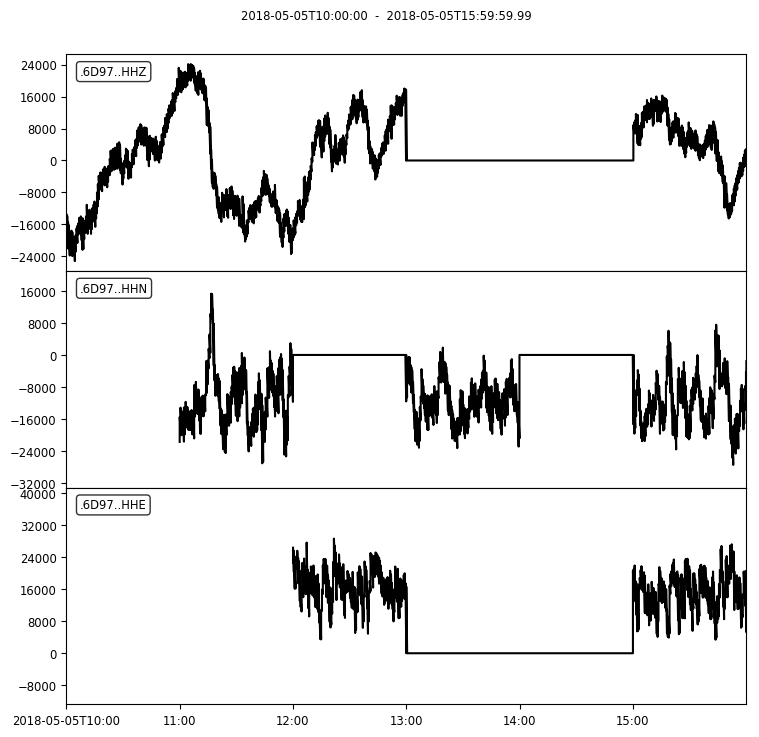

In [63]:
first_station_data.plot()

In [ ]:
stats_list = list()
times = first_station_data[0].times()
number_of_traces = len(first_station_data)
for time in times:
    number_of_active_traces = 0
    index = np.where(times==time)[0][0]
    for i in range(number_of_traces):
        trace = first_station_data[i]
        if trace.data[index] != None:
            number_of_active_traces+=1
    stats_list.append((time, number_of_active_traces))

1. вырезать куски данных, где происходили события. например, из суток возникает 3 файла. это будет триггер. 
2. матрица данных, вектор времён, какая трасса какой компоненте и какой станции соответствует, массив количества живых трасс - сделать свой класс. 

1. эти триггеры отдавать Елизавете
2. (Л)подобрать параметры для автоматического триггирования
3. далее пытаемся применить машинное обучение с полученным параметром триггирования

1. считываю все данные
2. все data из каждой трассы сохранить в матрицу
3. получится огромная матрица данных
4. None заменять нулями
5. добавить временной ряд
6. добавить количество живых трасс
7. в объекте так же сохраняем время начало отсчёта, время конца отсчёта

1. (Л) выяснить название триггер-файла
2. (Л) выяснить длину промежутка

1. UDINA_год_месяц_день_час_минута_секунда

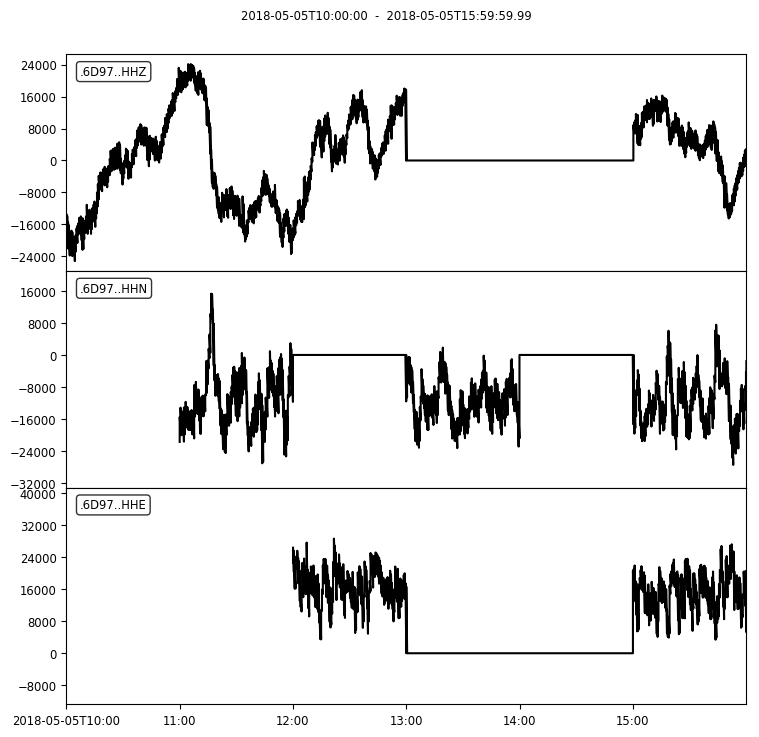

In [73]:
first_station_data.plot()

In [74]:
def trace_preprocessing(target_trace, canonical_times, npts):
    print('trace_preprocessing')
    target_times = target_trace.times('utcdatetime')
    if(len(target_times) < len(canonical_times)):
        target_trace.stats.starttime = canonical_times[0]
        target_trace.stats.npts = npts
        indexes = len(canonical_times) - len(target_times)
        zeros = np.zeros([indexes])
        new = np.hstack([zeros,target_trace.data])
        target_trace.data = new

In [77]:
def station_data_preprocessing(station_data):
    print('station_data_preprocessing')
    max_trace = None
    max_len = 0
    for trace in station_data.traces:
        if len(trace.data) > max_len:
            max_len = len(trace.data)
            max_trace = trace
    print('max trace = {0}'.format(max_trace))
    max_times = max_trace.times('utcdatetime')
    print('max trace times = {0}'.format(max_times))
    for trace in station_data.traces:
        trace_preprocessing(trace, max_times, max_trace.stats.npts)

In [81]:
station_data_preprocessing(first_station_data)

station_data_preprocessing
max trace = .6D97..HHN | 2018-05-05T11:00:00.000000Z - 2018-05-05T15:59:59.990000Z | 100.0 Hz, 1800000 samples
max trace times = [UTCDateTime(2018, 5, 5, 11, 0) UTCDateTime(2018, 5, 5, 11, 0, 0, 10000)
 UTCDateTime(2018, 5, 5, 11, 0, 0, 20000) ...
 UTCDateTime(2018, 5, 5, 15, 59, 59, 970000)
 UTCDateTime(2018, 5, 5, 15, 59, 59, 980000)
 UTCDateTime(2018, 5, 5, 15, 59, 59, 990000)]
trace_preprocessing
trace_preprocessing
trace_preprocessing


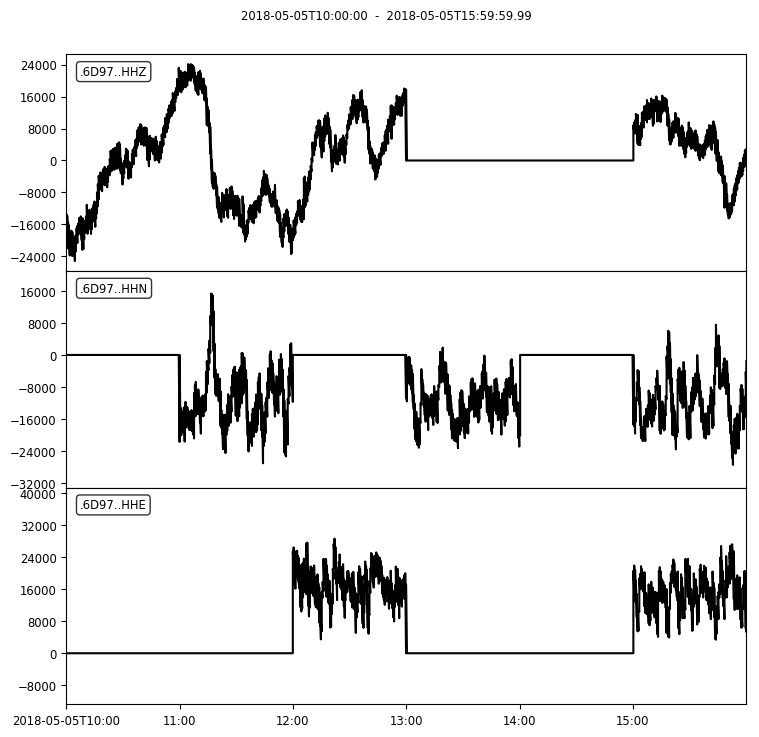

In [79]:
first_station_data.plot()